In [1]:
#倒库
import yfinance as yf  
import matplotlib.pyplot as plt 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM 

#下载股票数据作为训练集
tickerSymbol = 'AAPL'  #股票代码
data = yf.Ticker(tickerSymbol)
starttime = '2015-01-01' #开始下载日期
endtime = '2019-12-31' #结束日期
period = '1d'
prices = data.history(start = starttime,end = endtime,interval=period).Close
returns = prices.pct_change().dropna()

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(prices.values.reshape(-1,1))

prediction_days = 50 #使用过去XX天的数据预测未来的数据

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
	x_train.append(scaled_data[x-prediction_days:x,0])
	y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

#搭建模型
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction

#训练开始
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=70,batch_size=32)


Epoch 1/70


/opt/anaconda3/envs/wghs2/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0412
Epoch 2/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031
Epoch 3/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031
Epoch 4/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 5/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 6/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 7/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoch 8/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 9/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 10/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 11/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 12/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 13/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018
Epoch 14/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020
Epoch 15/70
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018
Epoch 16/70
38/

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


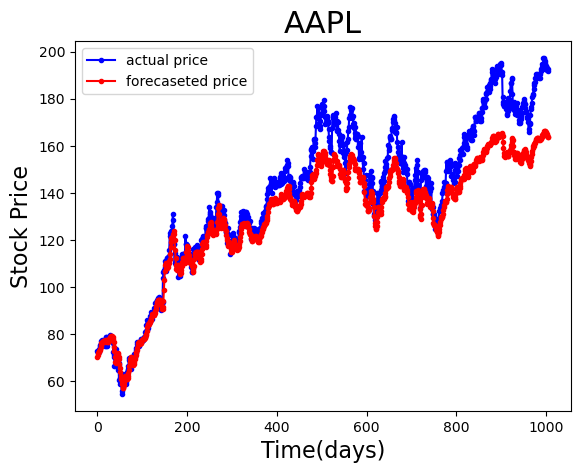

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[163.93134]]


In [12]:
#测试模型数据
test_start = '2020-01-01' #测试开始日期，理应为训练结束日期后的日期
test_end = '2024-01-01' #为了最后一个部分的代码能够预测下一个周期的股价，这个日期需要时今天，如果单纯测试的话随意设置

testdata = data.history(start = test_start,end = test_end,interval=period).Close
returns = testdata.pct_change().dropna()
actual_prices = testdata.values

total_dataset = pd.concat((prices,testdata), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(testdata)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

# for x in range(prediction_days, len(model_inputs)):
# 	x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
count = 0

while True:
    if count > len(testdata):
        break
    predicted_prices = model.predict(x_test, steps=1)
	
	#append the predicted price to the the end of the next model input
    x_test = np.append(x_test, predicted_prices)
    x_test = x_test[1:]
    count += 1

predicted_prices = model.predict(x_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

#可视化测试结果
plt.title(tickerSymbol, fontsize=22)
plt.plot(actual_prices,'b.-',label='actual price')
plt.plot(predicted_prices,'r.-',label='forecaseted price')
plt.xlabel('Time(days)',fontsize=16)
plt.ylabel('Stock Price',fontsize=16)
plt.legend()
plt.show()

#预测测试结束日期之后一天的股价
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1),0 ]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

